In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from energyflow.archs import EFN
from energyflow.utils import data_split

2023-09-03 04:28:52.227429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def read_data(file_path):
    data_file = open(file_path)
    lno = 0
    pTvals = []
    etavals = []
    phivals = []
    tvals = []
    events_input=[]
    events_target=[]
    data = []

    for line in data_file:
        lno+=1
        if (lno > 1000000000):
            break
        # enumber = int(line.split()[0])
        isprime = int(line.split()[1])
        E = float(line.split()[2])
        px = float(line.split()[3])
        py = float(line.split()[4])
        pz = float(line.split()[5])
        t = float(line.split()[6])
        
        pT = math.sqrt( px**2 + py**2 )
        p = math.sqrt( px**2 + py**2 + pz**2 )
        
        if (pz > 0):    
            eta = math.acosh(p / pT)
        else:
            eta = -math.acosh(p / pT)
        phi = math.atan( py / px )
        
        if (isprime==1):
            pTvals += [pT]
            etavals += [eta]
            phivals += [phi]
            tvals += [t]
            data += [[pT,eta,phi,t]]
        if (isprime==0):
            events_target += [[t]] 
            if (lno > 1):
                events_input += [data]
            data=[]

    events_input += [data]

    return events_input, events_target



In [3]:
def zero_padding(raw_data, max_num):

    input_zp = np.zeros([max_num,40,4])

    for i in range(0, max_num):
        for j in range(min(40,len(raw_data[i]))):
            input_zp[i,j,:] = raw_data[i][j]
        # np.random.shuffle(input_zp[i,:,:])

    return input_zp

In [4]:
def normalization(input, target, max_num):

    pT_weighted_time = []

    for jet in input:
        mask = jet[:,0] > 0
        yphi_avg = np.average(jet[mask,1:3], weights=jet[mask,0], axis=0)
        jet[mask,1:3] -= yphi_avg
        
        t_avg = np.average(jet[mask,3], weights=jet[mask,0], axis=0)
        pT_weighted_time += [[t_avg]]
        jet[mask,3] /= t_avg
        jet[mask,3] -= 1
        jet[mask,0] /= jet[:,0].sum()

    target = np.array(target[:max_num])
    target_scaled = target / pT_weighted_time - 1

    return pT_weighted_time, input, target_scaled

In [5]:
def preprocessing(input_path_list, max_num):

    data_input_dict = {}
    data_label_dict = {}
    data_pTweighted_dict = {}

    for key, data_path in enumerate(input_path_list):
        
        raw_input, raw_label = read_data(data_path)
        input_zp = zero_padding(raw_input, max_num)
        pTweighted_time, input_scaled, label_scaled = normalization(input_zp, raw_label, max_num)

        data_input_dict["input"+data_path] = input_scaled
        data_label_dict["label"+data_path] = label_scaled
        data_pTweighted_dict["pTweighted"+data_path] = pTweighted_time

    return data_pTweighted_dict, data_input_dict, data_label_dict

In [6]:
num_jets =30000 

input_path_list = ['/root/jettiming/data/jet_time_data_xt_05_etaM_0_etaJ_-2.txt']
pTweighted_dict, input_dict, label_dict = preprocessing(input_path_list, num_jets)

In [7]:
import tensorflow as tf
from keras import backend as K

efn = tf.keras.models.load_model('/root/jettiming/code/trained_model/mixed_efn_latent200_2config.h5', custom_objects={"K": K})

2023-09-03 04:29:01.775466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 04:29:01.780364: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
features_name = []

for i in range(40):
    constituent_f = [f'pT_{i}', f'eta_{i}', f'phi_{i}', f't_{i}']
    features_name.extend(constituent_f)

In [9]:
num_avg = 200

train_set = input_dict['input/root/jettiming/data/jet_time_data_xt_05_etaM_0_etaJ_-2.txt']
label_set = label_dict['label/root/jettiming/data/jet_time_data_xt_05_etaM_0_etaJ_-2.txt']
# Split the mixed data. The shuffle take place before splitting.

input_data = train_set[:num_avg,:,:]

pre_jet = [input_data[i].flatten() for i in range(len(input_data)) ]

In [77]:
import pandas as pd

avg_df = pd.DataFrame(pre_jet)
avg_df.columns = features_name

In [78]:
def warpped_pred(df):
    
    prediction = []
    
    df = np.array(df)
    dfa = df.reshape([len(df),40,4])
    input_z = dfa[:,:,0]
    input_X = dfa[:,:,1:]
    prediction = efn.predict([input_z, input_X])

    return prediction[:,0]

In [79]:
import shap

explainer = shap.Explainer(lambda x: warpped_pred(x), avg_df)

In [87]:
start_index = 10000
num_eva = 500

eva = np.array(train_set[start_index: (start_index + num_eva)])
e_pre_jet = eva.reshape([num_eva, 160])
edf = pd.DataFrame(e_pre_jet)
edf.columns = features_name
# print(e_pre_jet)
print(edf)

        pT_0     eta_0     phi_0       t_0      pT_1     eta_1     phi_1  \
0   0.389689  0.006151  0.020213 -0.006107  0.160595  0.048230  0.026682   
1   0.358025 -0.085742 -0.006780  0.053694  0.198130  0.106943 -0.005872   
2   0.873014 -0.006525 -0.009549  0.002909  0.040957 -0.017357  0.096181   
3   0.189303 -0.052820  0.081318  0.024092  0.155183  0.156835 -0.144434   
4   0.460894  0.018737 -0.000672 -0.012570  0.303109 -0.046481  0.007823   
5   0.478543  0.004645 -0.009978 -0.004427  0.238057 -0.002724 -0.016017   
6   0.352870 -0.006618  0.005475  0.002873  0.240674 -0.001300 -0.011790   
7   0.108648  0.163015 -0.174835 -0.099015  0.094473 -0.059578  0.254916   
8   0.457993  0.022944  0.096147 -0.019552  0.106571  0.137718 -0.117439   
9   0.498660 -0.022584 -0.015119  0.012549  0.233891  0.025591  0.024668   
10  0.104751 -0.032979  0.166401  0.010219  0.104192  0.322928 -0.059931   
11  0.495240 -0.031684 -0.006204  0.015022  0.169387  0.091496  0.161327   
12  0.386007

In [88]:
shap_values = explainer(edf)

# print(shap_values)

155/155 [==============================] - 2s 13ms/step


Permutation explainer:   4%|▍         | 2/50 [00:00<?, ?it/s]

149/149 [==============================] - 2s 14ms/step


Permutation explainer:   8%|▊         | 4/50 [00:24<03:28,  4.54s/it]

158/158 [==============================] - 2s 14ms/step


Permutation explainer:  10%|█         | 5/50 [00:36<05:50,  7.78s/it]

154/154 [==============================] - 2s 15ms/step


Permutation explainer:  12%|█▏        | 6/50 [00:46<06:04,  8.27s/it]

157/157 [==============================] - 2s 14ms/step


Permutation explainer:  14%|█▍        | 7/50 [00:54<06:04,  8.48s/it]

163/163 [==============================] - 2s 15ms/step


Permutation explainer:  16%|█▌        | 8/50 [01:04<06:14,  8.91s/it]

191/191 [==============================] - 2s 12ms/step


Permutation explainer:  18%|█▊        | 9/50 [01:16<06:41,  9.80s/it]

175/175 [==============================] - 2s 12ms/step


Permutation explainer:  20%|██        | 10/50 [01:27<06:52, 10.30s/it]

156/156 [==============================] - 2s 16ms/step


Permutation explainer:  22%|██▏       | 11/50 [01:36<06:27,  9.92s/it]

190/190 [==============================] - 3s 14ms/step


Permutation explainer:  24%|██▍       | 12/50 [01:49<06:43, 10.61s/it]

161/161 [==============================] - 2s 13ms/step


Permutation explainer:  26%|██▌       | 13/50 [01:59<06:26, 10.44s/it]

150/150 [==============================] - 2s 14ms/step


Permutation explainer:  28%|██▊       | 14/50 [02:07<05:55,  9.88s/it]

187/187 [==============================] - 3s 15ms/step


Permutation explainer:  30%|███       | 15/50 [02:19<06:10, 10.59s/it]

151/151 [==============================] - 2s 13ms/step


Permutation explainer:  32%|███▏      | 16/50 [02:28<05:42, 10.08s/it]

188/188 [==============================] - 3s 15ms/step


Permutation explainer:  34%|███▍      | 17/50 [02:41<05:54, 10.75s/it]

221/221 [==============================] - 3s 14ms/step


Permutation explainer:  36%|███▌      | 18/50 [02:50<05:29, 10.31s/it]

169/169 [==============================] - 2s 15ms/step


Permutation explainer:  38%|███▊      | 19/50 [03:00<05:17, 10.24s/it]

153/153 [==============================] - 2s 13ms/step


Permutation explainer:  40%|████      | 20/50 [03:09<04:52,  9.75s/it]

162/162 [==============================] - 3s 16ms/step


Permutation explainer:  42%|████▏     | 21/50 [03:17<04:32,  9.41s/it]

187/187 [==============================] - 3s 14ms/step


Permutation explainer:  44%|████▍     | 22/50 [03:28<04:36,  9.89s/it]

159/159 [==============================] - 3s 16ms/step


Permutation explainer:  46%|████▌     | 23/50 [03:38<04:24,  9.80s/it]

160/160 [==============================] - 2s 10ms/step


Permutation explainer:  48%|████▊     | 24/50 [03:46<04:04,  9.42s/it]

143/143 [==============================] - 2s 12ms/step


Permutation explainer:  50%|█████     | 25/50 [03:54<03:46,  9.05s/it]

158/158 [==============================] - 2s 12ms/step


Permutation explainer:  52%|█████▏    | 26/50 [04:04<03:40,  9.17s/it]

158/158 [==============================] - 2s 12ms/step


Permutation explainer:  54%|█████▍    | 27/50 [04:13<03:27,  9.01s/it]

155/155 [==============================] - 2s 15ms/step


Permutation explainer:  56%|█████▌    | 28/50 [04:22<03:17,  9.00s/it]

148/148 [==============================] - 2s 13ms/step


Permutation explainer:  58%|█████▊    | 29/50 [04:29<02:59,  8.55s/it]

152/152 [==============================] - 2s 12ms/step


Permutation explainer:  60%|██████    | 30/50 [04:38<02:51,  8.57s/it]

160/160 [==============================] - 2s 13ms/step


Permutation explainer:  62%|██████▏   | 31/50 [04:47<02:44,  8.67s/it]

155/155 [==============================] - 2s 13ms/step


Permutation explainer:  64%|██████▍   | 32/50 [04:55<02:32,  8.50s/it]

178/178 [==============================] - 3s 14ms/step


Permutation explainer:  66%|██████▌   | 33/50 [05:05<02:32,  8.98s/it]

158/158 [==============================] - 2s 10ms/step


Permutation explainer:  68%|██████▊   | 34/50 [05:14<02:24,  9.02s/it]

157/157 [==============================] - 2s 14ms/step


Permutation explainer:  70%|███████   | 35/50 [05:23<02:14,  8.95s/it]

145/145 [==============================] - 2s 13ms/step


Permutation explainer:  72%|███████▏  | 36/50 [05:32<02:05,  8.97s/it]

166/166 [==============================] - 2s 11ms/step


Permutation explainer:  74%|███████▍  | 37/50 [05:40<01:55,  8.89s/it]

181/181 [==============================] - 2s 10ms/step


Permutation explainer:  76%|███████▌  | 38/50 [05:50<01:51,  9.25s/it]

152/152 [==============================] - 2s 10ms/step


Permutation explainer:  78%|███████▊  | 39/50 [05:58<01:36,  8.79s/it]

153/153 [==============================] - 2s 16ms/step


Permutation explainer:  80%|████████  | 40/50 [06:07<01:28,  8.87s/it]

188/188 [==============================] - 2s 12ms/step


Permutation explainer:  82%|████████▏ | 41/50 [06:18<01:23,  9.30s/it]

152/152 [==============================] - 2s 12ms/step


Permutation explainer:  84%|████████▍ | 42/50 [06:26<01:12,  9.06s/it]

148/148 [==============================] - 2s 11ms/step


Permutation explainer:  86%|████████▌ | 43/50 [06:36<01:05,  9.35s/it]

152/152 [==============================] - 2s 16ms/step


Permutation explainer:  88%|████████▊ | 44/50 [06:45<00:56,  9.33s/it]

149/149 [==============================] - 2s 14ms/step


Permutation explainer:  90%|█████████ | 45/50 [06:54<00:45,  9.05s/it]

154/154 [==============================] - 2s 14ms/step


Permutation explainer:  92%|█████████▏| 46/50 [07:02<00:35,  8.76s/it]

171/171 [==============================] - 2s 12ms/step


Permutation explainer:  94%|█████████▍| 47/50 [07:12<00:27,  9.25s/it]

153/153 [==============================] - 2s 14ms/step


Permutation explainer:  96%|█████████▌| 48/50 [07:21<00:18,  9.06s/it]

183/183 [==============================] - 3s 16ms/step


Permutation explainer:  98%|█████████▊| 49/50 [07:34<00:10, 10.16s/it]

145/145 [==============================] - 2s 13ms/step


Permutation explainer: 100%|██████████| 50/50 [07:42<00:00,  9.62s/it]

187/187 [==============================] - 3s 15ms/step


Permutation explainer: 51it [07:53,  9.66s/it]                        

.values =
array([[-2.30803750e-04, -2.89150886e-05,  1.65281987e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.24865140e-05,  3.13039366e-04,  2.19816342e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.92148896e-03, -6.61829729e-04, -7.07935411e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-4.59008291e-04, -1.03798546e-04, -1.14105828e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.73562063e-04, -4.50283233e-04,  8.49717917e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.80756550e-04,  3.41604630e-03, -1.14902703e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

.base_values =
array([0.05980731, 0.05980731, 0.05980731, 0.05980731, 0.05980731,
       0.05980731, 0.05980731, 0.05980731, 0.05980731, 0.05980731,
       0.05980731, 0.05980731, 0.05980731, 0.05980731, 0.05980731,
       0.0598073

In [103]:
np.save('avg_200_edf10000+500_shap_values.npy', shap_values.values)
np.save('avg_200_edf10000+500_shap_basevalues.npy', shap_values.base_values)
np.save('avg_200_edf10000+500_shap_data.npy', shap_values.data)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


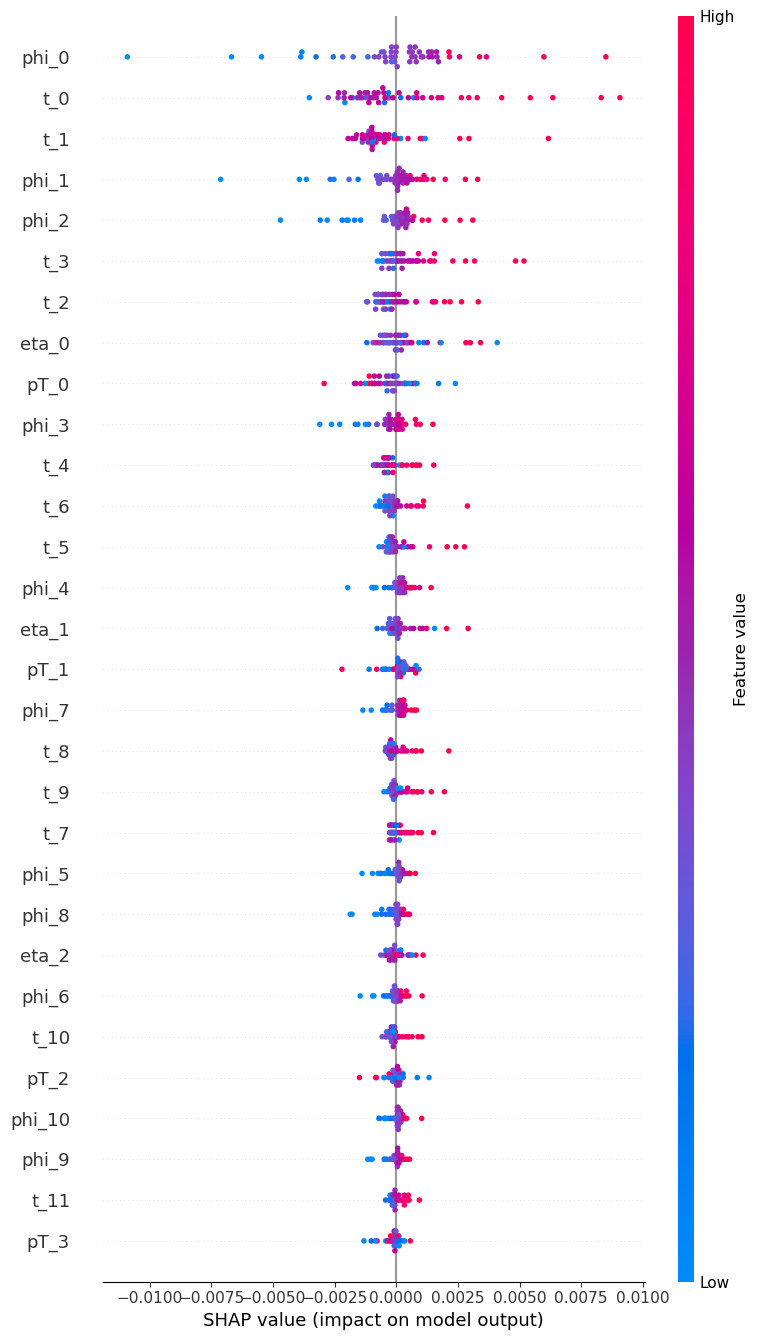

In [95]:
shap.summary_plot(shap_values, edf, features_name, max_display=30)

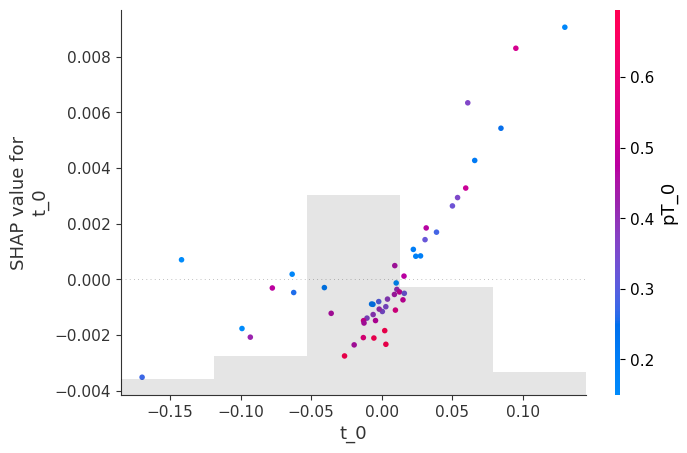

In [96]:
shap.plots.scatter(shap_values[:,'t_0'], color=shap_values[:,'pT_0'])

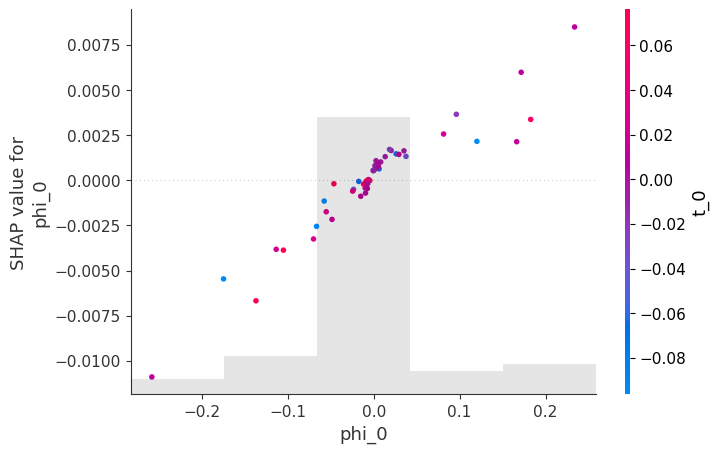

In [91]:
shap.plots.scatter(shap_values[:,'phi_0'], color=shap_values[:,'t_0'])

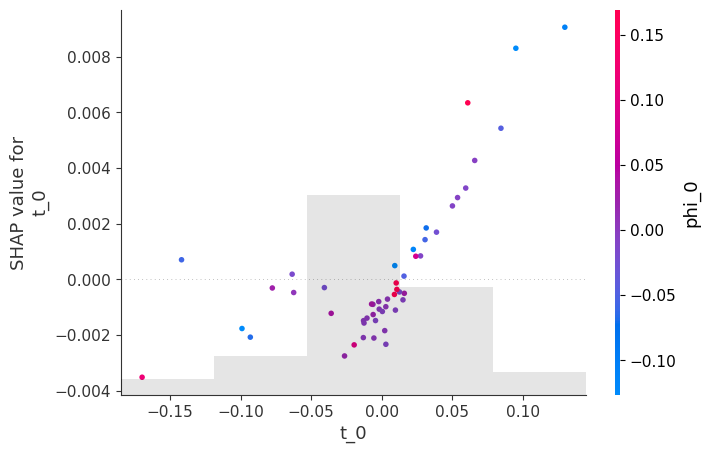

In [97]:
shap.plots.scatter(shap_values[:,'t_0'], color=shap_values[:,'phi_0'])

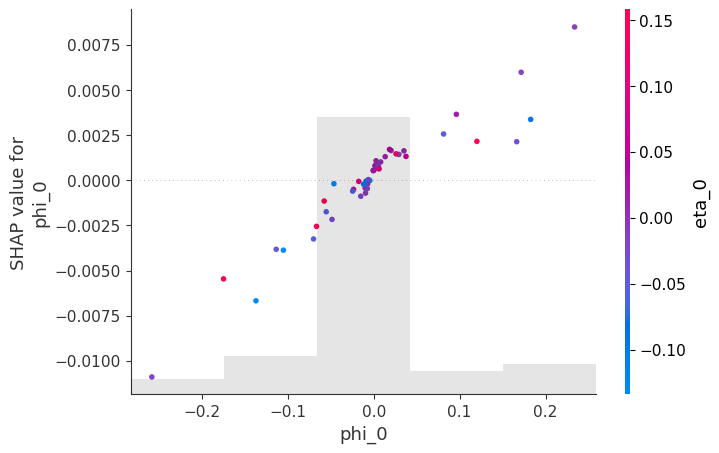

In [104]:
shap.plots.scatter(shap_values[:,'phi_0'], color=shap_values[:,'eta_0'])

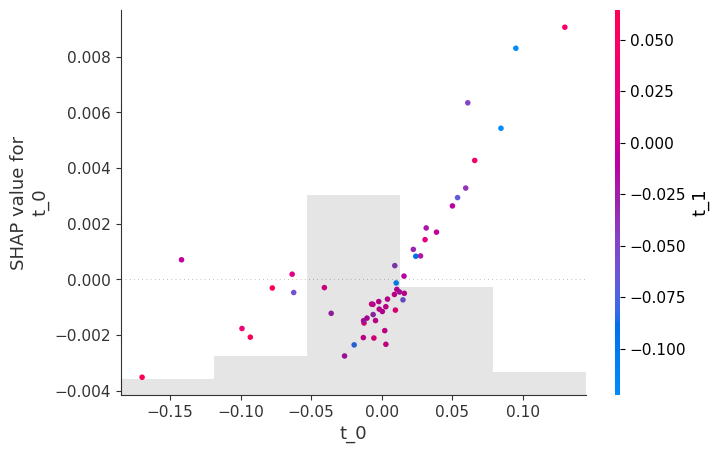

In [105]:
shap.plots.scatter(shap_values[:,'t_0'], color=shap_values[:,'t_1'])

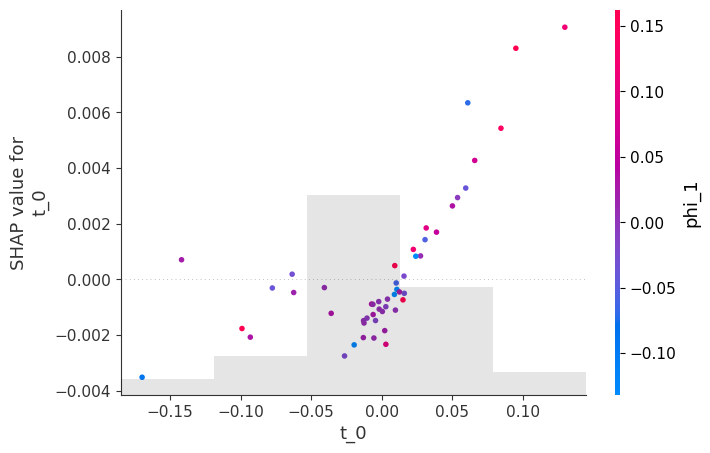

In [106]:
shap.plots.scatter(shap_values[:,'t_0'], color=shap_values[:,'phi_1'])

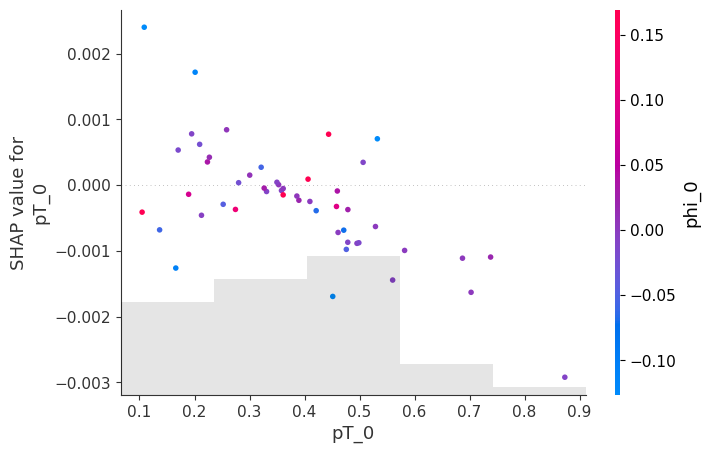

In [107]:
shap.plots.scatter(shap_values[:,'pT_0'], color=shap_values[:,'phi_0'])